# Reduced-dimension Emulator: Reaction-Diffusion example

### Overview

In this example, we aim to create an _emulator_ to generate solutions to a 2D parameterized reaction-diffusion problem governed by the following partial differential equations:

$$
\dot{u} = (1 - (u^2 + v^2)) u + \beta (u^2 + v^2) v + d (u_{xx} + u_{yy}),
$$

$$
\dot{v} = -\beta (u^2 + v^2) u + (1 - (u^2 + v^2)) v + d (v_{xx} + v_{yy}),
$$

where:

- $ u $ and $ v $ are the concentrations of two species,
- $ \beta $ and $ d $ control the reaction and diffusion terms.

This system exhibits complex spatio-temporal dynamics such as spiral waves.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import autoemulate as ae
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

from autoemulate.experimental_design import LatinHypercube
from autoemulate.experimental.simulations.reaction_diffusion import simulate_reaction_diffusion
from autoemulate.experimental.compare import AutoEmulate
from autoemulate.datasets import fetch_data

save = False
train = False

### 1) Data generation

Data are computed using a numerical [_simulator_](https://github.com/dynamicslab/pysindy/blob/master/examples/10_PDEFIND_examples.ipynb) using Fourier spectral method.
The simulator takes two inputs: the reaction parameter $\beta$ and the diffusion parameter $d$.

We sample 50 sets of inputs `X` using Latin Hypercube sampling and run the simulator for those inputs to get the solutions `Y`.


In [2]:
n = 50

# Reaction-diffusion parameters
beta = (1., 2.) # lower and upper bounds for the reaction coefficient
d = (0.05, 0.3) # lower and upper bounds for the diffusion coefficient
lhd = LatinHypercube([beta, d])
n_samples = 50
X = lhd.sample(n_samples)

#data_folder = "../../data/reaction_diffusion"
data_folder =  "../../../data/reactiondiffusion1/processed" 
if not os.path.exists(data_folder):
    os.makedirs(data_folder)  
X_file = os.path.join(data_folder, "parameters.csv")
Y_file = os.path.join(data_folder, "outputs.csv")

if train:
    # Run the simulator to generate data 
    U, V = zip(*[simulate_reaction_diffusion(x, n=n, T=10) for x in tqdm(X)])
    U = np.stack(U)
    V = np.stack(V)

    # Let's consider as output the concentration of the specie U
    Y = U.reshape(n_samples, -1)

    if save:
        # Save the data
        pd.DataFrame(X).to_csv(X_file, index=False)
        pd.DataFrame(Y).to_csv(Y_file, index=False)
else:
    # Load the data
    X, Y = fetch_data('reactiondiffusion1')

print(f"shapes: input X: {X.shape}, output Y: {Y.shape}\n")

shapes: input X: (50, 2), output Y: (50, 2500)



`X` and `Y` are matrices where each row represents one run of the simulation. In the input matrix `X` the two columuns indicates the input parameters (reaction $\beta$ and diffusion $d$ parameters, respetively).
In the output matrix `Y` each column indicates a spatial location where the solution (i.e. the concentration of $u$ at final time $T=10$) is computed. <br>
We consider a 2D spatial grid of $50\times 50$ points, therefore each row of `Y` corresponds to a 2500-dimensional vector!

Let’s now plot the simulated data to see how the reaction-diffusion pattern looks like.


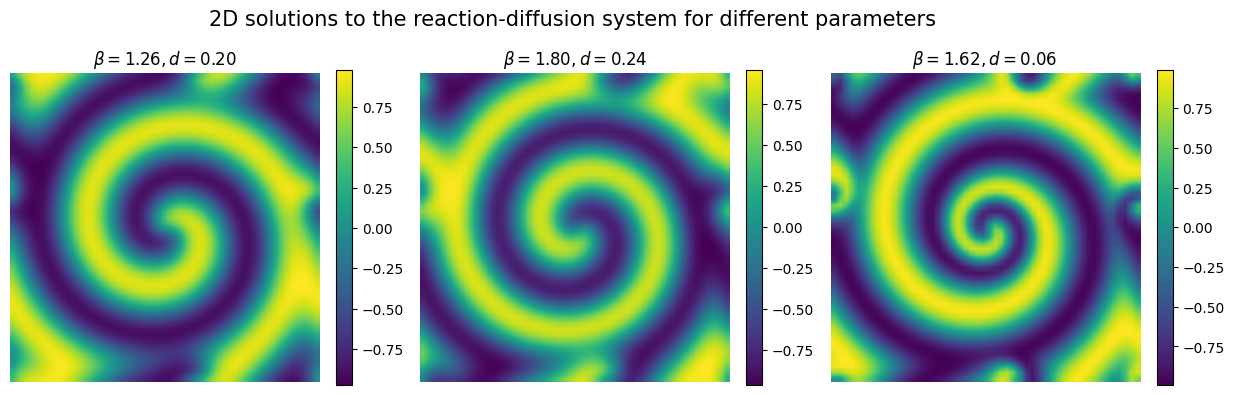

In [3]:
plt.figure(figsize=(15,4.5))
for param in range(3):
  plt.subplot(1,3,1+param)
  plt.imshow(Y[param].reshape(n,n), interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title(r'$\beta = {:.2f}, d = {:.2f}$'.format(X[param][0], X[param][1]), fontsize=12)
  plt.colorbar(fraction=0.046)
plt.suptitle('2D solutions to the reaction-diffusion system for different parameters', fontsize=15)
plt.show()

In [4]:
from autoemulate.experimental.callbacks.early_stopping import EarlyStopping
from autoemulate.experimental.emulators import GaussianProcessExact, GaussianProcessExactCorrelated
from autoemulate.experimental.emulators.gaussian_process.kernel import rbf, rbf_times_linear
from autoemulate.experimental.emulators.gaussian_process.mean import constant_mean, linear_mean
from autoemulate.experimental.emulators.transformed.base import TransformedEmulator
from autoemulate.experimental.transforms import *
import torch 
from torch.optim.lr_scheduler import LRScheduler

x, y = torch.Tensor(X), torch.Tensor(Y)
em = TransformedEmulator(
    x,
    y,
    model= GaussianProcessExact,
    x_transforms=[StandardizeTransform()],
    y_transforms=[
        StandardizeTransform(),
        PCATransform(n_components=16)

    ],
    epochs=500,
    lr=0.5,
    mean_module_fn=constant_mean,
    covar_module_fn=rbf_times_linear,
    # The scheduler and early_stopping seem optional but speed up the fit
    scheduler_cls=LRScheduler,
    scheduler_kwargs={"policy": "ReduceLROnPlateau", "patience": 5, "factor": 0.5},
    early_stopping=EarlyStopping(),
)



In [5]:
test_idx = [np.array([13, 39, 30, 45, 17, 48, 26, 25, 32, 19])]
train_idx = np.setdiff1d(np.arange(len(x)), test_idx)

In [6]:
# Fit on all data
em.fit(x[train_idx], y[train_idx])

## Test predictions


In [7]:
gp_final = em

In [8]:
# Get predictions for the full dataset
y_true = y[test_idx].numpy()
y_pred_dis = em.predict(x[test_idx])
y_pred = y_pred_dis.mean.numpy()
y_std_pred = y_pred_dis.stddev.numpy()


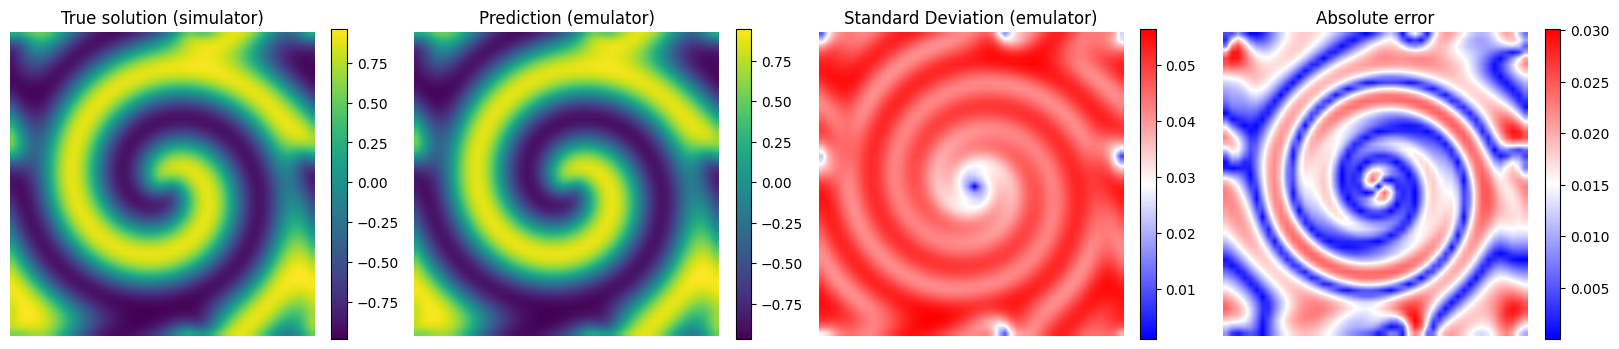

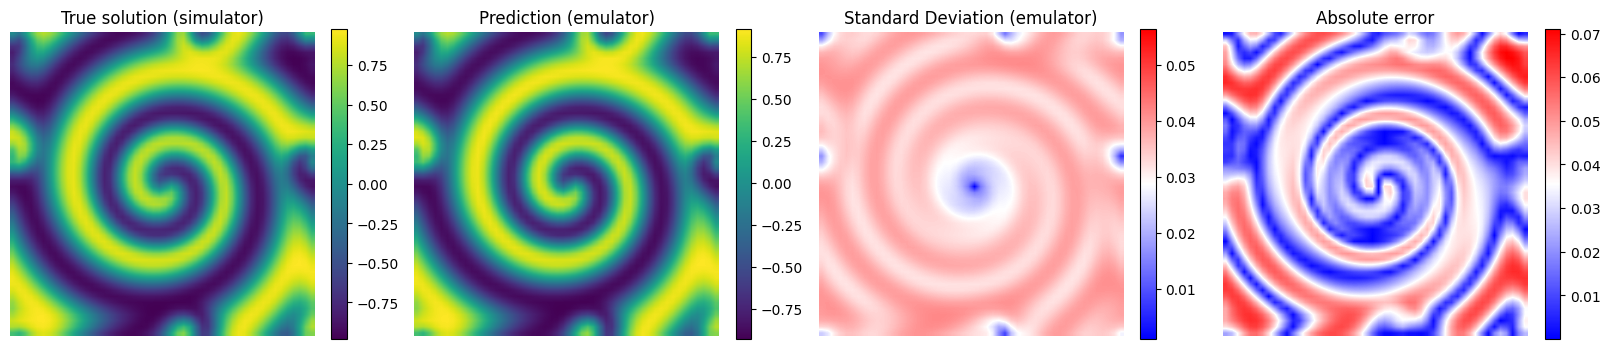

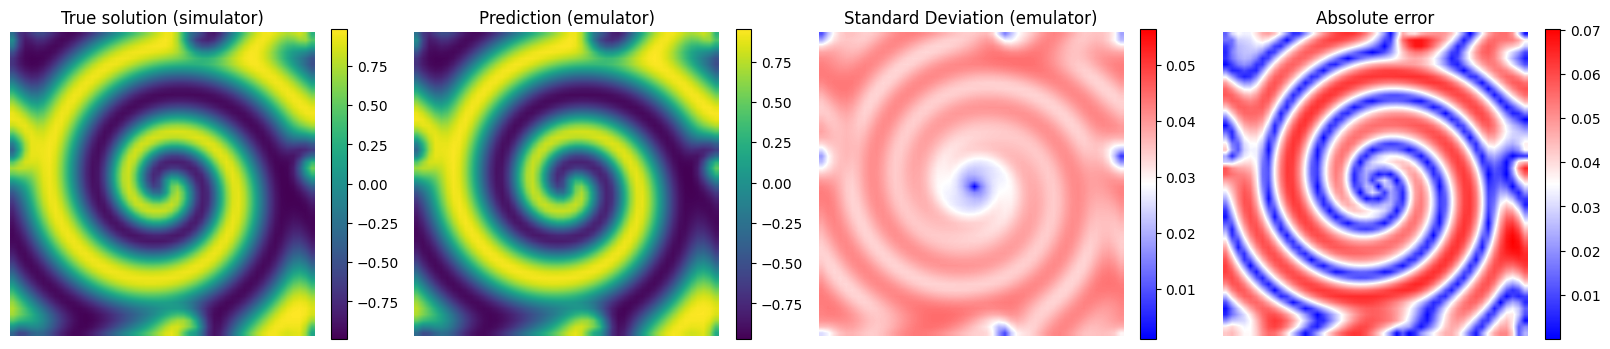

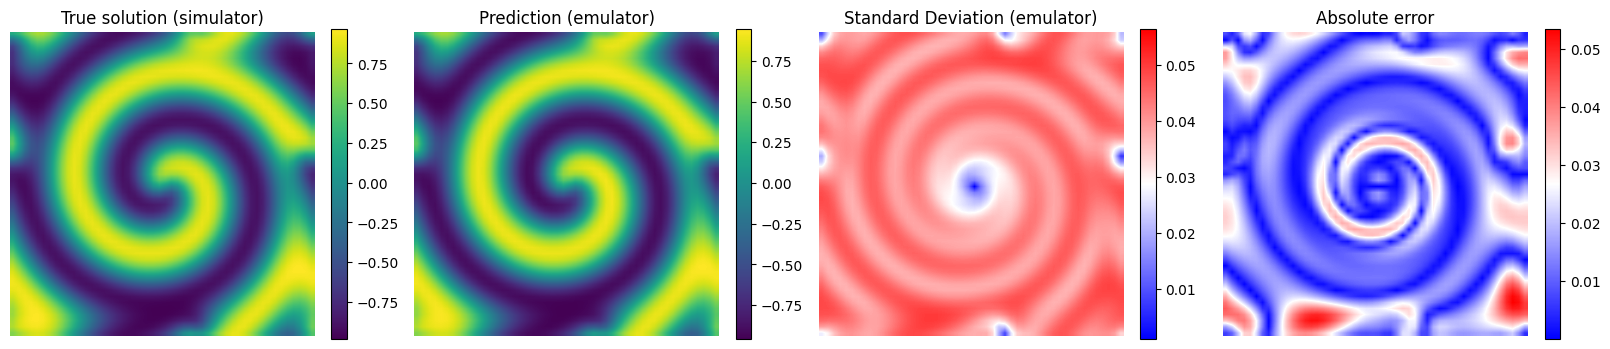

In [9]:
# Plot the results for some unseen (test) parameter instances
params_test = [0,1,2,3]

for param_test in params_test:
  plt.figure(figsize=(20,4.5))
  plt.subplot(1,4,1)
  plt.imshow(y_true[param_test].reshape(n,n), interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title('True solution (simulator)', fontsize=12)
  plt.colorbar(fraction=0.046)

  plt.subplot(1,4,2)
  plt.imshow(y_pred[param_test].reshape(n,n), interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title('Prediction (emulator)', fontsize=12)
  plt.colorbar(fraction=0.046)

  plt.subplot(1,4,3)
  plt.imshow(y_std_pred[param_test].reshape(n,n), cmap = 'bwr', interpolation='bilinear', vmax = np.max(y_std_pred[params_test]))
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title('Standard Deviation (emulator)', fontsize=12)
  plt.colorbar(fraction=0.046)

  plt.subplot(1,4,4)
  plt.imshow(np.abs(y_pred[param_test] - y_true[param_test]).reshape(n,n), cmap = 'bwr', interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title('Absolute error', fontsize=12)
  plt.colorbar(fraction=0.046)

  # plt.suptitle(r'Results for test parameters: $\beta = {:.2f}, d = {:.2f}$'.format(X[em.test_idxs][param_test][0], X[em.test_idxs][param_test][1]), fontsize=12)
  plt.show()